# Part 1 - Sparse Identification of Nonlinear Dynamical systems (SINDy)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.6?filepath=examples/2_introduction_to_sindy.ipynb)

## Example
Suppose we have measurements of the position of a particle obeying the following dynamical system at different points in time:

$$
	\frac{d}{dt} \begin{bmatrix} x \\ y \end{bmatrix}
	= \begin{bmatrix} -2x \\ y \end{bmatrix}
	= \begin{bmatrix} -2 & 0 \\ 0 & 1 \end{bmatrix}
	\begin{bmatrix} x \\ y \end{bmatrix}
$$

Note that this system of differential equations decouples into two differential equations whose solutions are simply $x(t) = x_0e^{-2t}$ and $y(t) = y_0e^t$, where $x_0 = x(0)$ and $y_0=y(0)$ are the initial conditions.

Using the initial conditions $x_0 = 3$ and $y_0 = \tfrac{1}{2}$, we construct the data matrix $X$.

In [52]:
import numpy as np
import pysindy as ps

In [53]:
t = np.linspace(0, 1, 100)
x = 3 * np.exp(-2 * t)
y = 0.5 * np.exp(t)
X = np.stack((x, y), axis=-1)  # First column is x, second is y

We can select a differentiation method from the `differentiation` submodule.

In [54]:
differentiation_method = ps.FiniteDifference(order=2)

# We could instead call ps.differentiation.FiniteDifference(order=2)

While we could use this method to compute $\dot X$ "by hand," it is often more convenient to pass it into the `SINDy` object and let the computation of $\dot X$ be handled automatically.

The candidate library can be specified with an object from the `feature_library` submodule, which will also be passed into the `SINDy` object.

In [55]:
feature_library = ps.PolynomialLibrary(degree=3)

# Note: We could instead call ps.feature_library.PolynomialLibrary(degree=3)

Next we select which optimizer should be used.

In [56]:
optimizer = ps.STLSQ(threshold=0.2)

# Note: We could instead call ps.optimizers.STLSQ(threshold=0.2)

Finally, we bring these three components together in one `SINDy` object.

In [57]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)

Following the `scikit-learn` workflow, we first instantiate a `SINDy` class object with the desired properties, then fit it to the data in separate step.

In [58]:
model.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3), feature_names=['x', 'y'],
      optimizer=STLSQ(threshold=0.2))

We can inspect the governing equations discovered by the model and check whether they seem reasonable with the `print` function.

In [59]:
model.print()

(x)' = -2.000 x
(y)' = 1.000 y


Once the SINDy model has been fit we can use it to evolve new initial conditions forward in time with the `simulate` function.

In [66]:
x0 = 6
y0 = -0.1

t_test = np.linspace(0, 1, 100)
x_test = x0 * np.exp(-2 * t_test)
y_test = y0 * np.exp(t_test)

sim = model.simulate([x0, y0], t=t_test)

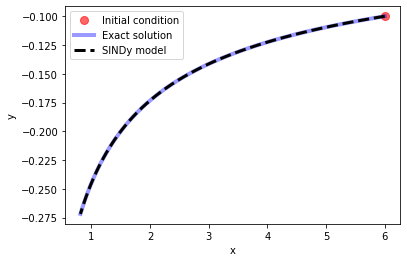

In [67]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [68]:
# Populate the library with trigonometric functions
feature_library = ps.FourierLibrary()

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)
model.fit(X, t=t)
model.print()

(x)' = 0.772 sin(1 x) + 2.097 cos(1 x) + -2.298 sin(1 y) + -3.115 cos(1 y)
(y)' = 1.362 sin(1 y) + -0.222 cos(1 y)


[[3.         0.5       ]
 [3.02999904 0.5050761 ]
 [3.05939798 0.51020373]
 [3.08820904 0.51538342]
 [3.1164439  0.52061569]
 [3.14411409 0.52590109]
 [3.17123089 0.53124014]
 [3.19780539 0.53663339]
 [3.22384841 0.5420814 ]
 [3.24937058 0.54758472]
 [3.27438233 0.55314391]
 [3.29889386 0.55875953]
 [3.32291517 0.56443217]
 [3.34645607 0.5701624 ]
 [3.36952618 0.5759508 ]
 [3.39213491 0.58179796]
 [3.41429148 0.58770449]
 [3.43600493 0.59367099]
 [3.45728411 0.59969805]
 [3.47813771 0.6057863 ]
 [3.49857425 0.61193637]
 [3.51860207 0.61814886]
 [3.53822937 0.62442443]
 [3.55746413 0.63076371]
 [3.57631421 0.63716735]
 [3.5947873  0.643636  ]
 [3.61289094 0.65017032]
 [3.63063252 0.65677098]
 [3.64801928 0.66343865]
 [3.66505832 0.67017401]
 [3.68175659 0.67697775]
 [3.6981209  0.68385056]
 [3.71415794 0.69079314]
 [3.72987425 0.69780621]
 [3.74527624 0.70489048]
 [3.76037021 0.71204667]
 [3.7751623  0.7192755 ]
 [3.78965857 0.72657773]
 [3.80386491 0.73395409]
 [3.81778714 0.74140534]


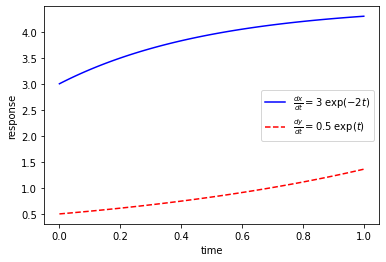

In [71]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function that returns dz/dt
def model(z,t):
    dxdt = 3 * np.exp(-2 * t)
    dydt = 0.5 * np.exp(t)
    dzdt = [dxdt,dydt]
    return dzdt

# initial condition
z0 = [3,0.5]

# time points
t = np.linspace(0, 1, 100)

# solve ODE
z = odeint(model,z0,t)

print(z)

# plot results
plt.plot(t,z[:,0],'b-',label=r'$\frac{dx}{dt}=3 \; \exp(-2t)$')
plt.plot(t,z[:,1],'r--',label=r'$\frac{dy}{dt}=0.5\; \exp(t)$')
plt.ylabel('response')
plt.xlabel('time')
plt.legend(loc='best')
plt.show()

# Part 2 - Comparative Study for the solution of Lorenz equation using ODEINT and RK-Solve

SINDy for Lorenz is the case study for Brunton's paper so it's not included here.

In [74]:
# Compare RK-Solve w/ ODEINT
import numpy as np #import numpy as usual
import matplotlib.pyplot as plt #import plotting package
# also import specific functions to enable use without prefix to mae code a bit cleaner
from numpy.linalg import norm
from numpy.random import rand #use 'rand(m)' and 'rand(m,n)' to create 1D and 2D arrays of random floats on [0,1]
from numpy import dot, eye, zeros


# RK-Solve Method


def rk_solve(f,y0,t,order=4):

    step_method = rk2_step # Temporary default value until rk4_step is implemented
    #####################
    # Specify the order #
    if 1 == order:
        step_method =  euler_step
    elif 2 == order:
        step_method = rk2_step
    elif 4 == order:
        step_method = rk4_step
    elif 4 != order:
        print("Requested order not in [1,2,4]. Using default order 4.")

    n = t.size
    m = y0.size #determine size of the dependent variable array
    y = [y0] #list to store 1D numpy array for each time
    for i in range(n-1):
        y_new = step_method(f,y[i],t[i],t[i+1]) #compute next step as before
        y.append(y_new)
        #NOTICE: For numpy array, would need loop to assign values into y one element at a time
        #for j in range(m): 
            #y[i+1,j] = y_new[j]
    return np.array(y)

def rk2_step(f,y,t0,t1):

    f0 = f(y,t0)
    h  = t1-t0
    
    #compute euler estimate for half step
    y1 = y + 0.5*h*f0
    t1 = t0 + 0.5*h
    
    #compute midstep rate estimate
    f1 = f(y1,t1)
    
    #take full step using midstep rate estimate 
    y_new = y + h*f1
    return y_new

def rk4_step(f,y,t0,t1):

    h = t1 - t0
    f1 = f( y, t0 )
    f2 = f( y + 0.5 * h * f1, t0 + 0.5 * h )
    f3 = f( y + 0.5 * h * f2, t0 + 0.5 * h )
    f4 = f( y + h * f3, t0 + h )
    y_new = y + h* ( f1 + 2.0 * ( f2 + f3 ) + f4 ) / 6.0
    return y_new

Text(0.5, 0.92, 'RK45')

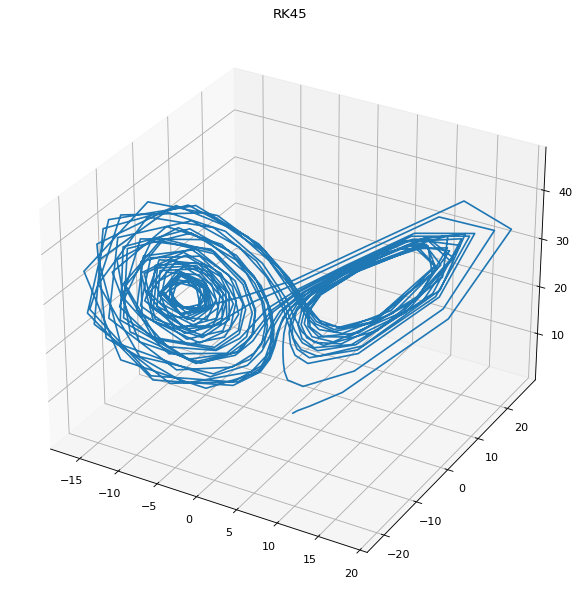

In [80]:
from matplotlib.pyplot import figure
def lorenz(t, state, sigma, beta, rho):
    x, y, z = state
     
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
     
    return [dx, dy, dz]
 
sigma = 10.0
beta = 8.0 / 3.0
rho = 28.0
 
p = (sigma, beta, rho)  # Parameters of the system
 
y0 = [1.0, 1.0, 1.0]  # Initial state of the system

solve_ivp_rk45 = solve_ivp(lorenz, t_span, y0, args=p,
                            method='RK45')

fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(solve_ivp_rk45.y[0, :],
        solve_ivp_rk45.y[1, :],
        solve_ivp_rk45.y[2, :])
ax.set_title("RK45")

In [76]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
def lorenz(t, state, sigma, beta, rho):
    x, y, z = state
     
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
     
    return [dx, dy, dz]
 
sigma = 10.0
beta = 8.0 / 3.0
rho = 28.0
 
p = (sigma, beta, rho)  # Parameters of the system
 
y0 = [1.0, 1.0, 1.0]  # Initial state of the system

Text(0.5, 0.92, 'solve_ivp')

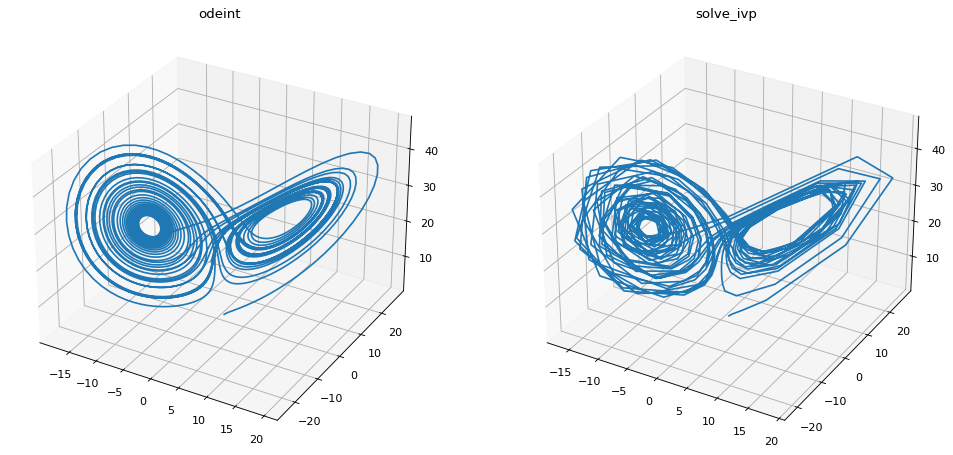

In [77]:
t_span = (0.0, 40.0)
t = np.arange(0.0, 40.0, 0.01)
 
result_odeint = odeint(lorenz, y0, t, p, tfirst=True)
result_solve_ivp = solve_ivp(lorenz, t_span, y0, args=p)
 
fig = plt.figure(figsize=(15,15), dpi=80)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(result_odeint[:, 0],
        result_odeint[:, 1],
        result_odeint[:, 2])
ax.set_title("odeint")
 
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot(result_solve_ivp.y[0, :],
        result_solve_ivp.y[1, :],
        result_solve_ivp.y[2, :])
ax.set_title("solve_ivp")

The solve ivp solution is less smooth, as we can see (because it is calculated at fewer time points).
Furthermore, the odeint interface anticipates t, an array of time points for which the solution is to be calculated (the interval between time points defines the system's temporal resolution).
The solve ivp interface, on the other hand, expects t span, a tuple containing the start and end times of the simulation interval (the temporal resolution is determined by solve ivp on its own, based on the integration method and the desired accuracy of the solution). 

Text(0.5, 0.92, 'LSODA')

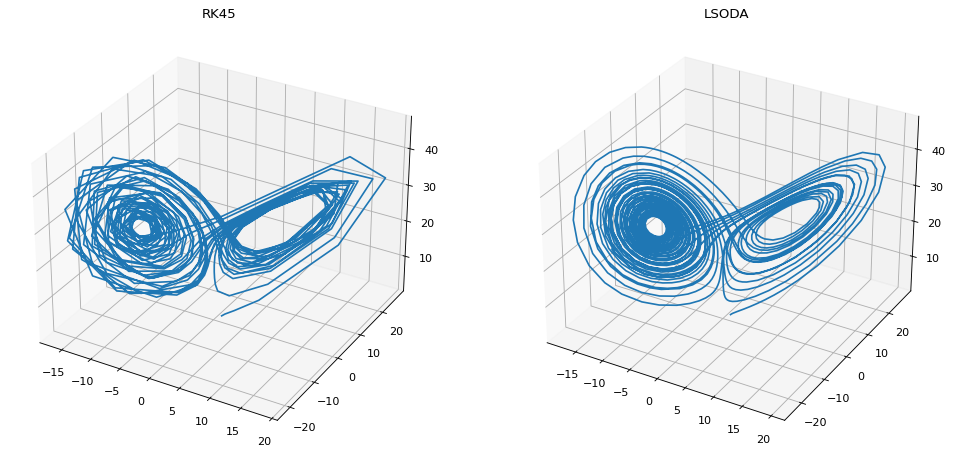

In [78]:
solve_ivp_rk45 = solve_ivp(lorenz, t_span, y0, args=p,
                            method='RK45')
solve_ivp_lsoda = solve_ivp(lorenz, t_span, y0, args=p,
                           method='LSODA')
 
fig = plt.figure(figsize=(15,15), dpi=80)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(solve_ivp_rk45.y[0, :],
        solve_ivp_rk45.y[1, :],
        solve_ivp_rk45.y[2, :])
ax.set_title("RK45")
 
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot(solve_ivp_lsoda.y[0, :],
        solve_ivp_lsoda.y[1, :],
        solve_ivp_lsoda.y[2, :])
ax.set_title("LSODA")

The LS0DA is more accurate than RK45, but still not as accurate as ODEINT. To get the exact same result from LS0DA as odeint, we must pass it the exact time points we want to solve with the t_eval parameter.

Text(0.5, 0.92, 'solve_ivp LSODA')

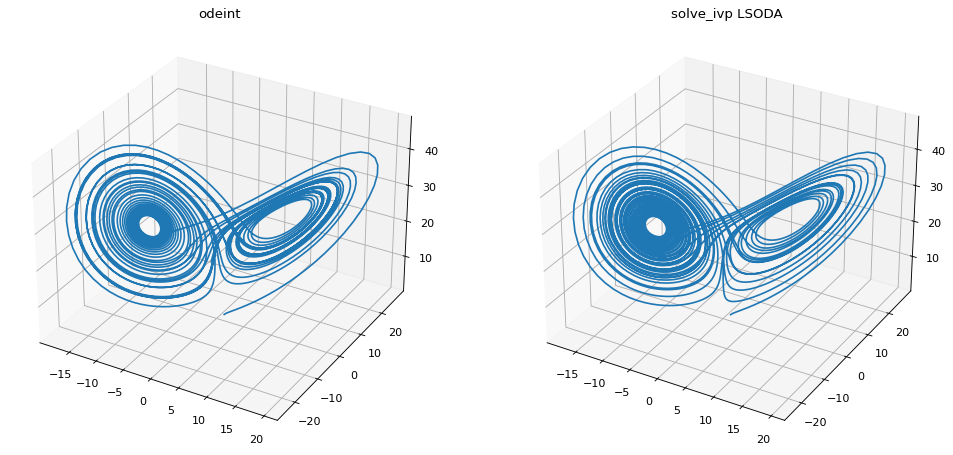

In [79]:
t = np.arange(0.0, 40.0, 0.01)
result_odeint = odeint(lorenz, y0, t, p, tfirst=True)
result_solve_ivp = solve_ivp(lorenz, t_span, y0, args=p,
                             method='LSODA', t_eval=t)
 
fig = plt.figure(figsize=(15,15), dpi=80)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(result_odeint[:, 0],
        result_odeint[:, 1],
        result_odeint[:, 2])
ax.set_title("odeint")
 
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot(result_solve_ivp.y[0, :],
        result_solve_ivp.y[1, :],
        result_solve_ivp.y[2, :])
ax.set_title("solve_ivp LSODA")

# Part 3 - Physics-Informed Neural Networks